# Churn with causality 

This analysisi will show the main reason why clients stop using our server

In [1]:
# Main libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import datetime
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
import chart_studio.plotly as py
import cufflinks as cf
from lifelines import KaplanMeierFitter
cf.go_offline()
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine

# Loading data
Loading churn and not churn data to clean and prepare for causal model

In [2]:
# churn and not churn databases
hs_churn = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/mx-so-daily-churn-data.csv')
hs_nochurn = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/mx-so-batch-1.csv')

In [3]:
# columns/variables for churn data base
hs_churn.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'Doctor - Verified [batch]',
       'Email Confirmed', 'First Name', 'Last Name', 'Contact owner', 'City',
       'HubSpot Team', 'Postal Code', 'Country [batch]', 'Close Date',
       'Doctor - Onboarding Completed at (non commercial)',
       'Doctor - Profile Scoring',
       'Doctor - Gross Price of Premium Subscription - Currency type  [Batch]',
       'Doctor - Website - became customer at [batch]',
       'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Contact result [Manual]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Scoring at [WF]',
       ' Doctor - Pre-onboarding completed [Batch]',
       ' Doctor - Pre-onboarding completed at [Batch]',
       'Doctor - After first cal

In [4]:
# columns/variables for not churn 
hs_nochurn.columns 

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'HubSpot Team', 'Country [batch]', 'Close Date',
       'Doctor - Onboarding Completed at (non commercial)',
       'Doctor - Profile Scoring',
       'Doctor - Gross Price of Premium Subscription - Currency type  [Batch]',
       'Doctor - Website - became customer at [batch]',
       'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Contact result [Manual]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Scoring at [WF]',
       ' Doctor - Pre-onboarding completed [Batch]',
       ' Doctor - Pre-onboarding completed at [Batch]',
       'Doctor - After first call at - Stage in the process [WF]',
       'Doctor - Bought website service? [B

In [5]:
# Most important varible selection
hs_churn_clean = hs_churn[['Contact ID','Doctor - Has calendar [Batch]','Contact owner','City','HubSpot Team',
                          'Doctor - Profile Scoring','Internal - Contact result [Manual]',
                          'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',' Doctor - Pre-onboarding completed [Batch]',
                          'Doctor - Bought website service? [Batch]','Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
                          'Doctor - Onboarding owner (CX) [WF]','Doctor - Sold with website [Manual]','Doctor - Stage in the process [WF]',
                          'Doctor/Facility - Lifecycle stage [WF]','Doctor/Facility - Onboarding type [WF/manual]','Doctor/Facility - Payment method [Batch]',
                          'Docplanner Category [batch]', 'Doctor - Commercial [Batch]']]
hs_nochurn_clean = hs_nochurn[['Contact ID','Doctor - Has calendar [Batch]','Contact owner','City','HubSpot Team',
                          'Doctor - Profile Scoring','Internal - Contact result [Manual]',
                          'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',' Doctor - Pre-onboarding completed [Batch]',
                          'Doctor - Bought website service? [Batch]','Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
                          'Doctor - Onboarding owner (CX) [WF]','Doctor - Sold with website [Manual]','Doctor - Stage in the process [WF]',
                          'Doctor/Facility - Lifecycle stage [WF]','Doctor/Facility - Onboarding type [WF/manual]','Doctor/Facility - Payment method [Batch]',
                          'Docplanner Category [batch]', 'Doctor - Commercial [Batch]']]

In [6]:
hs_churn_clean.head(2) # testing if data frame column order adjust

,Contact ID,Doctor - Has calendar [Batch],Contact owner,City,HubSpot Team,Doctor - Profile Scoring,Internal - Contact result [Manual],Internal - Last Sales Owner [WF],Internal - Sold by (DA),Doctor - Pre-onboarding completed [Batch],...,Doctor - Health Group [WF],Doctor - Last CS Owner [WF],Doctor - Onboarding owner (CX) [WF],Doctor - Sold with website [Manual],Doctor - Stage in the process [WF],Doctor/Facility - Lifecycle stage [WF],Doctor/Facility - Onboarding type [WF/manual],Doctor/Facility - Payment method [Batch],Docplanner Category [batch],Doctor - Commercial [Batch]
0,58020208,No,Data Quality,San Luis Potosi,Permission level 9,12.0,Deal Created [TR],janet ramirez herrera,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bank transfer,NaN,0
1,58020464,No,María del Carmen Curiel González,Naucalpan de Juárez,MX_CS_FAR_1,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bank transfer,NaN,0


In [7]:
hs_nochurn_clean.head(2) # testing if data frame column order adjust

,Contact ID,Doctor - Has calendar [Batch],Contact owner,City,HubSpot Team,Doctor - Profile Scoring,Internal - Contact result [Manual],Internal - Last Sales Owner [WF],Internal - Sold by (DA),Doctor - Pre-onboarding completed [Batch],...,Doctor - Health Group [WF],Doctor - Last CS Owner [WF],Doctor - Onboarding owner (CX) [WF],Doctor - Sold with website [Manual],Doctor - Stage in the process [WF],Doctor/Facility - Lifecycle stage [WF],Doctor/Facility - Onboarding type [WF/manual],Doctor/Facility - Payment method [Batch],Docplanner Category [batch],Doctor - Commercial [Batch]
0,58015869,Yes,Miguel Varela Cid,NaN,MX_CS_FAR_1,7.0,NaN,NaN,NaN,NaN,...,Sick,NaN,NaN,NaN,farming,Farming,Standard onboarding,Bank transfer,Instasuperzombie,1
1,58016381,Yes,Francisco Flores González,NaN,MX_CS_FAR_1,12.0,NaN,Daniela Ortega,NaN,NaN,...,Mid-Healthy,Adelaida Garcia Espino,NaN,NaN,farming,Farming,Standard onboarding,Bank transfer,Engaged,1


In [8]:
print(hs_churn_clean.shape, hs_nochurn_clean.shape) # validating shapes for dataframes append

(8271, 21) (10156, 21)


In [9]:
churn_nochurn = hs_churn_clean.append(hs_nochurn_clean, ignore_index = True) # appending dataframes

# Data cleaning 
Cleaning null contacts and changing column types.

In [10]:
churn_nochurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18427 entries, 0 to 18426
Data columns (total 21 columns):
Contact ID                                       18427 non-null int64
Doctor - Has calendar [Batch]                    18418 non-null object
Contact owner                                    14066 non-null object
City                                             8306 non-null object
HubSpot Team                                     13980 non-null object
Doctor - Profile Scoring                         18427 non-null float64
Internal - Contact result [Manual]               10211 non-null object
Internal - Last Sales Owner [WF]                 14649 non-null object
Internal - Sold by (DA)                          11358 non-null object
 Doctor - Pre-onboarding completed [Batch]       597 non-null object
Doctor - Bought website service? [Batch]         18412 non-null float64
Doctor - Health Group [WF]                       10110 non-null object
Doctor - Last CS Owner [WF]              

In [11]:
general = churn_nochurn.fillna('-') # Filling null values wiht '-'

In [12]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18427 entries, 0 to 18426
Data columns (total 21 columns):
Contact ID                                       18427 non-null int64
Doctor - Has calendar [Batch]                    18427 non-null object
Contact owner                                    18427 non-null object
City                                             18427 non-null object
HubSpot Team                                     18427 non-null object
Doctor - Profile Scoring                         18427 non-null float64
Internal - Contact result [Manual]               18427 non-null object
Internal - Last Sales Owner [WF]                 18427 non-null object
Internal - Sold by (DA)                          18427 non-null object
 Doctor - Pre-onboarding completed [Batch]       18427 non-null object
Doctor - Bought website service? [Batch]         18427 non-null object
Doctor - Health Group [WF]                       18427 non-null object
Doctor - Last CS Owner [WF]            

In [14]:
# discretizing numerical variables
churn_nochurn['Doctor - Profile Scoring']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(churn_nochurn['Doctor - Profile Scoring'].values)

In [ ]:
general.drop(columns = ['Internal - Contact result [Manual]','Internal - Last Sales Owner [WF]',
                       'Internal - Sold by (DA)',' Doctor - Pre-onboarding completed [Batch]',
                       'Doctor - Bought website service? [Batch]'],inplace = True)

In [22]:
non_numeric_columns=list(general.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

['Doctor - Health Group [WF]',
 'Doctor - Last CS Owner [WF]',
 'Doctor - Onboarding owner (CX) [WF]',
 'Doctor - Sold with website [Manual]',
 'Doctor - Stage in the process [WF]',
 'Doctor/Facility - Lifecycle stage [WF]',
 'Doctor/Facility - Onboarding type [WF/manual]',
 'Doctor/Facility - Payment method [Batch]',
 'Docplanner Category [batch]']

In [23]:
le=LabelEncoder()

for col in non_numeric_columns:
    general[col]=le.fit_transform(general[col])

general.head()

,Contact ID,Doctor - Has calendar [Batch],Contact owner,City,HubSpot Team,Doctor - Profile Scoring,Doctor - Health Group [WF],Doctor - Last CS Owner [WF],Doctor - Onboarding owner (CX) [WF],Doctor - Sold with website [Manual],Doctor - Stage in the process [WF],Doctor/Facility - Lifecycle stage [WF],Doctor/Facility - Onboarding type [WF/manual],Doctor/Facility - Payment method [Batch],Docplanner Category [batch],Doctor - Commercial [Batch]
0,58020208,1,47,344,49,12.0,0,0,0,0,0,0,0,1,0,0
1,58020464,1,129,264,24,8.0,0,0,0,0,0,0,0,1,0,0
2,58018941,1,0,164,0,15.0,0,0,0,0,0,0,0,1,0,0
3,57991291,1,0,352,0,5.0,0,0,0,0,0,0,0,1,0,0
4,58020730,1,47,122,49,7.0,0,0,0,0,0,0,0,1,0,0


# CausalNex
CasualNex will be used to estimate if a customer becomes churn, based on the characteristics provided by local CRM (variables)

In [24]:
# Model Initialization
sm = StructureModel()
sm

In [ ]:
#general.drop(columns = ['Doctor - Bought website service? [Batch]', 'Contact ID'], inplace = True) # droping non reliablevariables as it doesn't contain numbers

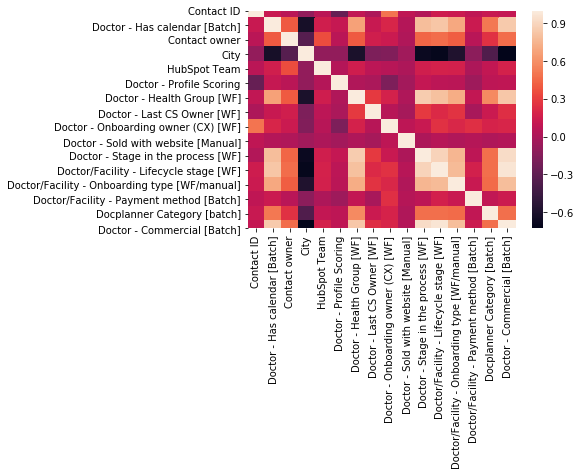

In [28]:
sns.heatmap(general.corr());

In [29]:
general.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]', 'Contact owner', 'City',
       'HubSpot Team', 'Doctor - Profile Scoring',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Sold with website [Manual]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]'],
      dtype='object')

In [30]:
# counter to erase columns with more categories
for i in general.columns:
    if len(general[i].unique())>100:
        print(i, len(general[i].unique()))

Contact ID 18425
Contact owner 175
City 462


In [34]:
sm = from_pandas(general) # initializing model with data 

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



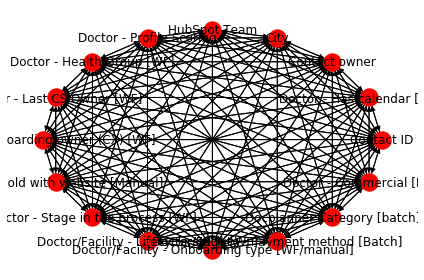

In [35]:
from causalnex.plots import plot_structure
# Plotting general connections calculated with causality 
fig, ax, nodes=plot_structure(sm)

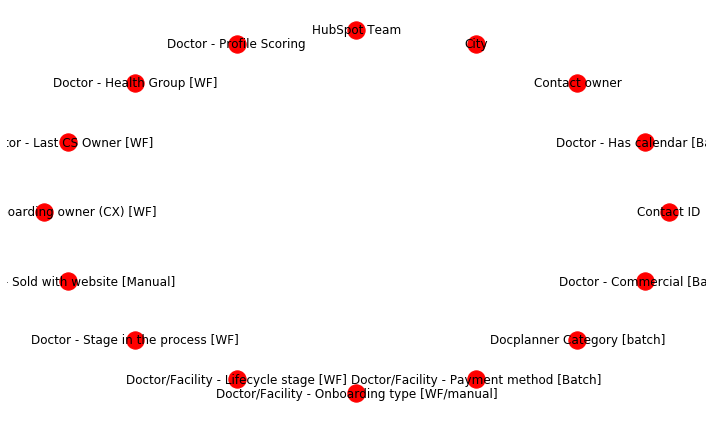

In [38]:
# Plotting most relevant connections, weight greater than .8
plt.rcParams['figure.figsize'] = (10.0, 6.0)
sm.remove_edges_below_threshold(.8)
fig , ax  , nodes = plot_structure(sm);

In [40]:
## Memory Optimization
for i in general.select_dtypes('integer').columns:
    general[i] = pd.to_numeric(general[i], downcast = 'integer')
general.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18427 entries, 0 to 18426
Data columns (total 16 columns):
Contact ID                                       18427 non-null int32
Doctor - Has calendar [Batch]                    18427 non-null int8
Contact owner                                    18427 non-null int16
City                                             18427 non-null int16
HubSpot Team                                     18427 non-null int8
Doctor - Profile Scoring                         18427 non-null float64
Doctor - Health Group [WF]                       18427 non-null int8
Doctor - Last CS Owner [WF]                      18427 non-null int8
Doctor - Onboarding owner (CX) [WF]              18427 non-null int8
Doctor - Sold with website [Manual]              18427 non-null int8
Doctor - Stage in the process [WF]               18427 non-null int8
Doctor/Facility - Lifecycle stage [WF]           18427 non-null int8
Doctor/Facility - Onboarding type [WF/manual]    18427 no

In [41]:
bn = BayesianNetwork(sm) # Bayesian Network initialized 

ValueError: The given structure has 16 separated graph components. Please make sure it has only one.

In [ ]:
bn = bn.fit_node_states(general1)  # Training the model with all the data base to avoid splitting nodes

In [ ]:
bn = bn.fit_cpds(general1, method = 'BayesianEstimator', bayes_prior = 'K2' ) # Probability calculations for nodes using Bayesian estimator with dirichlet conditions as pseudo _counts = 1

In [ ]:
bn.cpds['Docplanner Category [batch]']  # probabilies for one of the most important variables with node combinations

In [ ]:
z = bn.cpds['Docplanner Category [batch]']
z.shape

In [ ]:
predictions=bn.predict(general1, 'Docplanner Category [batch]') # Predicting, next category for every contact

In [ ]:
predictions1 = bn.predict(general1, 'Doctor - Commercial [Batch]') # Predicting if every contact will become a churn or not 

In [ ]:
classification_report(bn, general1, 'Docplanner Category [batch]') # Classification for all categories

In [ ]:
# Categories Distribution
labels, counts=np.unique(general1['Docplanner Category [batch]'], return_counts=True)
list(zip(labels, counts)) 

# Survivial Method

In [ ]:
# Invoices Data
churn_dwh = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/batch0.csv') # Churn invoice data
nochurn_dwh1 = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/batch1.csv')# Not Churn invoice data

In [ ]:
churn_dwh.head(2)

In [ ]:
nochurn_dwh1.head(2)

In [ ]:
dwh = churn_dwh.append(nochurn_dwh1, ignore_index = True) # Invoice append for churn and no churn 

In [ ]:
dwh.head(2)

In [ ]:
dwh.shape

In [ ]:
# Left function to extract only the date 
dwh['min_commercial_from'] = dwh.commercial_from.str[:10]
dwh['max_commercial_from'] = dwh.last_commercial.str[:10]

In [ ]:
dwh['min_commercial_from']=pd.to_datetime(dwh['min_commercial_from'],format='%Y-%m-%d') # Date format
dwh['max_commercial_from']=pd.to_datetime(dwh['max_commercial_from'],format='%Y-%m-%d') # Date Format
dwh['tenure'] = dwh['max_commercial_from'] - dwh['min_commercial_from'] # Tenure Calculation
dwh.tenure = dwh.tenure.apply(lambda x: x.days)  # Tenure as a number 

In [ ]:
dwh.drop(columns = ['commercial_from', 'last_commercial'])
dwh.head(2)

In [ ]:
# Tenure distribution
import plotly.express as px
fig = px.histogram(dwh, x = 'tenure')
fig.show()

In [ ]:
# Merging Invoice database with general database so every client has a tenure 
total=pd.merge(churn_nochurn,dwh, left_on = 'Contact ID', right_on = 'hubspot_id')
total.shape

In [ ]:
total.fillna('-',inplace = True) # Filling null values
total.isnull().sum()

# Kaplan Meier

In [ ]:
# Kaplan Meier Funtion for survival Method
def survival(data, group_field, time_field, event_field):
    
    modelo=KaplanMeierFitter()
    
    res=[]
    for i in data[group_field].unique():
        grupo=data[data[group_field]==i]
        t=grupo[time_field]
        e=grupo[event_field]
        
        modelo.fit(t, e, label=str(i))
        
        res.append(modelo.survival_function_)
        
    survival=pd.concat(res, axis=1)
    return survival

In [ ]:
rates = survival(total, 'Docplanner Category [batch]','tenure' , 'Doctor - Commercial [Batch]')

In [ ]:
# Survival Graphics for categories
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retención', title='Tasa de retención por permanencia y categoría')

In [ ]:
# Survival Graphics for Calendar
rates = survival(total, 'Doctor - Has calendar [Batch]','tenure' , 'Doctor - Commercial [Batch]')
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retención', title='Tasa de retención por permanencia y calendario(Y/N)')

In [ ]:
# Survival Graphics for Group
rates = survival(total, 'Doctor - Health Group [WF]','tenure' , 'Doctor - Commercial [Batch]')
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retención', title='Tasa de retención por permanencia y Health Group')